In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

base_path = '/content/drive/MyDrive/CottonStress'

# Load the data (assuming data is stored in npy files for images)
img_size = 128
date = '8_18'  # Change this based on your dataset
data = np.load(f'{base_path}/twri_rgb_6832_cotton_{img_size}x{img_size}_{date}.npy')

# Load the labels (assuming labels are stored in an Excel file)
labels_path = f'{base_path}/labels_rgb.xlsx'
labels = pd.read_excel(labels_path)

y_label = labels['class'].values

# Make sure data and labels match in length
if data.shape[0] != len(labels):
    min_length = min(data.shape[0], len(labels))
    data = data[:min_length]
    y_label = labels['class'].values[:min_length]

# Remove the filler type (assuming class 0 is filler)
new_data_without_filler = np.zeros((5376, img_size, img_size, 3))  # Change size if needed
new_y_label_without_filler = np.zeros(5376, dtype=int)
i = 0
for idx, val in enumerate(y_label):
    if val != 0:
        new_data_without_filler[i] = data[idx]
        new_y_label_without_filler[i] = y_label[idx]
        i += 1

# Update data and labels
data = new_data_without_filler
y_label = new_y_label_without_filler - 1  # Adjust to 0-based indexing


In [ ]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(data, y_label, test_size=0.3, random_state=42)

# Normalize the image data to [0, 1]
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define class names
class_names = ['rainfed', 'fully irrigated', 'percent deficit', 'time delay']

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
import tensorflow as tf

# Load the pre-trained InceptionV3 model without the top layer
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

def create_pre_trained_model(local_weights_file):
    """
    Function to load the pre-trained InceptionV3 model and freeze its layers.
    Args:
        local_weights_file (str): Path to the weights file for the pre-trained model.

    Returns:
        pre_trained_model (Model): InceptionV3 model without the top layer, with weights loaded and frozen.
    """
    # Initialize the InceptionV3 model with input size 128x128x3 (RGB images)
    # and exclude the top classification layers
    pre_trained_model = InceptionV3(input_shape=(128, 128, 3),
                                    include_top=False, weights=None)

    # Load the pre-trained weights into the model
    # pre_trained_model.load_weights(local_weights_file)

    # Freeze all the layers of the pre-trained model to prevent them from being updated during training
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

# Create the pre-trained model by calling the function
pre_trained_model = create_pre_trained_model(local_weights_file)

# Extract the output of a specific layer from the pre-trained model
# 'mixed7' is an intermediate layer of the InceptionV3 model
last_output = pre_trained_model.get_layer('mixed7').output

# Add custom layers on top of the pre-trained model for fine-tuning
# First custom Conv2D layer with 32 filters, 3x3 kernel, ReLU activation, and same padding
x = layers.Conv2D(32, (5, 5), activation='relu', padding="same")(last_output)

# MaxPooling2D layer to reduce spatial dimensions by 2x
x = layers.MaxPooling2D((2, 2))(x)

# Second custom Conv2D layer with 64 filters, 3x3 kernel, ReLU activation, and same padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(x)

# Another MaxPooling2D layer to further reduce spatial dimensions
x = layers.MaxPooling2D((2, 2))(x)

# Third custom Conv2D layer with 64 filters, 3x3 kernel, ReLU activation, and same padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding="same")(x)

# Flatten the output of the Conv2D layers to create a 1D feature vector for the dense layers
x = layers.Flatten()(x)

# Fully connected (dense) layer with 64 neurons and sigmoid activation
x = layers.Dense(64, activation='sigmoid')(x)

# Output layer with 4 neurons (one for each class); no activation function here since we're using logits
x = layers.Dense(4)(x)

# Create the full model by specifying the input (pre-trained model input)
# and output (custom classification layers' output)
model = Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# The model is now ready for training on your dataset!


In [ ]:
import numpy as np
import pandas as pd

# Display the number of trainable and non-trainable parameters
trainable_params = np.sum([np.prod(var.shape) for var in model.trainable_weights])
non_trainable_params = np.sum([np.prod(var.shape) for var in model.non_trainable_weights])

# Create a DataFrame to display the information
params_data = {
    "Parameter Type": ["Trainable Parameters", "Non-Trainable Parameters", "Total Parameters"],
    "Count": [trainable_params, non_trainable_params, trainable_params + non_trainable_params]
}

# Convert the dictionary to a pandas DataFrame for a table-like structure
params_df = pd.DataFrame(params_data)

# Display the DataFrame in a clean table format
print(params_df)


             Parameter Type    Count
0      Trainable Parameters   635300
1  Non-Trainable Parameters  8975264
2          Total Parameters  9610564


In [24]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

history = model.fit(train_images, train_labels,
                    epochs=70,
                    verbose=2,
                    validation_data=(test_images, test_labels),
                    callbacks=[callback])


Epoch 1/70
118/118 - 5s - 39ms/step - accuracy: 0.6707 - loss: 0.7478 - val_accuracy: 0.6541 - val_loss: 0.7591
Epoch 2/70
118/118 - 4s - 32ms/step - accuracy: 0.6779 - loss: 0.7573 - val_accuracy: 0.6379 - val_loss: 0.8050
Epoch 3/70
118/118 - 6s - 47ms/step - accuracy: 0.6885 - loss: 0.7304 - val_accuracy: 0.6689 - val_loss: 0.7467
Epoch 4/70
118/118 - 4s - 31ms/step - accuracy: 0.6745 - loss: 0.7398 - val_accuracy: 0.6714 - val_loss: 0.7338
Epoch 5/70
118/118 - 5s - 41ms/step - accuracy: 0.6636 - loss: 0.7586 - val_accuracy: 0.6739 - val_loss: 0.7343
Epoch 6/70
118/118 - 3s - 29ms/step - accuracy: 0.6923 - loss: 0.7200 - val_accuracy: 0.6503 - val_loss: 0.7907
Epoch 7/70
118/118 - 6s - 48ms/step - accuracy: 0.6782 - loss: 0.7332 - val_accuracy: 0.6826 - val_loss: 0.7290
Epoch 8/70
118/118 - 3s - 28ms/step - accuracy: 0.6907 - loss: 0.7215 - val_accuracy: 0.6652 - val_loss: 0.7552
Epoch 9/70
118/118 - 5s - 44ms/step - accuracy: 0.6734 - loss: 0.7345 - val_accuracy: 0.6379 - val_loss:

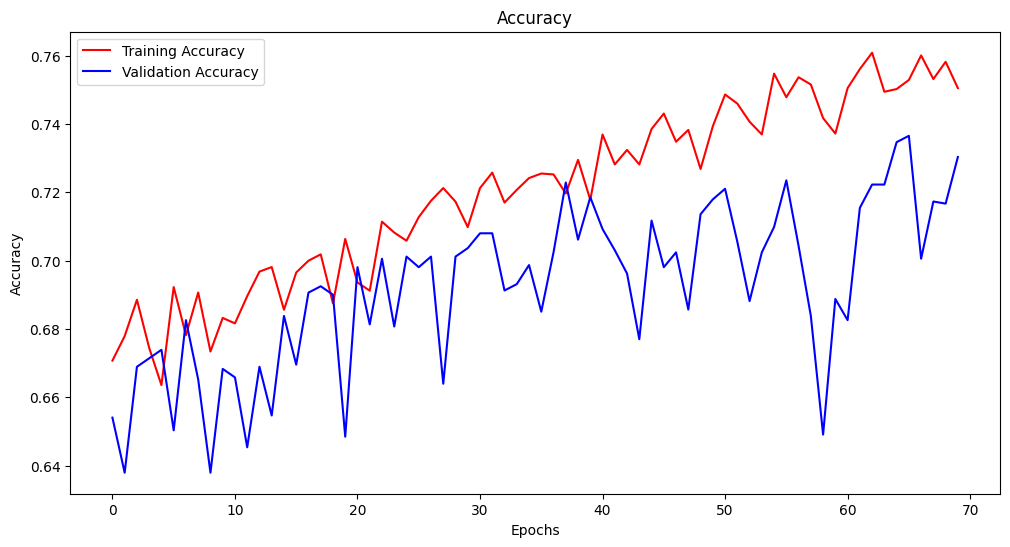

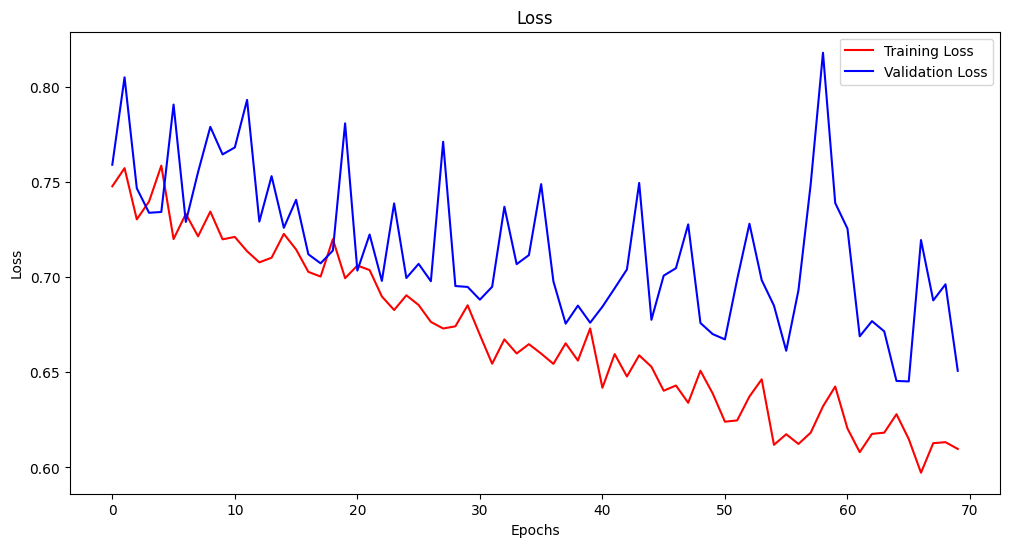

In [25]:
import matplotlib.pyplot as plt

# Extract accuracy and loss for training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


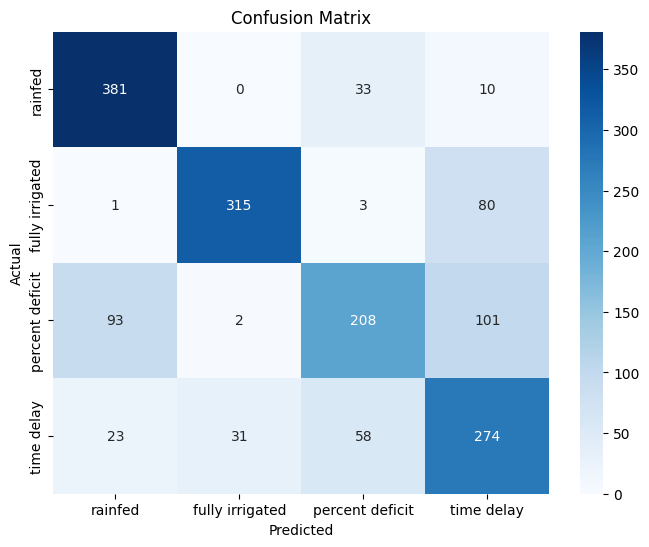

                 precision    recall  f1-score   support

        rainfed       0.77      0.90      0.83       424
fully irrigated       0.91      0.79      0.84       399
percent deficit       0.69      0.51      0.59       404
     time delay       0.59      0.71      0.64       386

       accuracy                           0.73      1613
      macro avg       0.74      0.73      0.73      1613
   weighted avg       0.74      0.73      0.73      1613



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test data
test_preds = model.predict(test_images)
test_preds = np.argmax(test_preds, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(test_labels, test_preds, target_names=class_names))